<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [108]:
import sys
sys.path.append('/Users/jessegrabowski/Documents/Python/gEconpy/')

import gEconpy as ge
import gEconpy.plotting as gp
import sympy as sp
from gEconpy.shared.utilities import eq_to_ss
import numpy as np

def make_python_func(args, cse_dict, expr):
    printer = sp.printing.numpy.NumPyPrinter()
    code = 'def f_x(' + ','.join(args) + '):\n'
    code += '\n'.join([f'\t{x} = {y}' for x, y in cse_dict])
    code += '\n\n'
    code += '\tout = np.array([' + "\t\t".join([printer.doprint(x) + ',\n' for x in expr]) + '\t])'
    code += '\n\n'
    code += '\treturn out'
    
    code = code.replace('numpy', 'np')
    exec(code)
    f = locals()['f_x']
    return f

In [364]:
mod = ge.gEconModel('../gcn_files/rbc_2_region.gcn')

/Users/jessegrabowski/Documents/Python/gEconpy/gEconpy/classes/model.py:1576: UserWarning: Simplification via try_reduce was requested but not possible because the system is not well defined.
  warn(
/Users/jessegrabowski/Documents/Python/gEconpy/gEconpy/classes/model.py:1639: UserWarning: Removal of constant variables was requested but not possible because the system is not well defined.
  warn(
/Users/jessegrabowski/Documents/Python/gEconpy/gEconpy/classes/model.py:291: UserWarning: The model does not appear correctly specified, there are 37 equations but 39 variables. It will not be possible to solve this model. Please check the specification using available diagnostic tools, and check the GCN file for typos.
  warn(message)


Model Building Complete.
Found:
	37 equations
	39 variables
	2 stochastic shocks
		 0 / 2 has a defined prior. 
	17 parameters
		 0 / 17 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 


In [365]:
globals().update({x.base_name:x for x in mod.variables})
globals().update({'lam': mod.variables[31]})
globals().update({x.name:x for x in mod.free_param_dict.to_sympy()})

In [366]:
bc = mod.system_equations[0]

In [367]:
for i, x in enumerate(mod.system_equations):
    print(i, x)

0 -1*psi_1*(-1*1 + omega_t/psi_omega)**2/2 - 1*psi_2*(omega_t/omega_t-1 - 1*1)**2*omega_t/2 + Div_A_t + Div_B_t - P_A_t*omega_t*(C_A_t + I_A_t) - P_B_t*(1 - omega_t)*(C_B_t + I_B_t) + omega_t*(Div_A_i_t + K_A_t-1*r_A_t + L_A_t*w_A_t) + (1 - omega_t)*(Div_B_i_t + K_B_t-1*r_B_t + L_B_t*w_B_t)
1 I_A_t - K_A_t + K_A_t-1*(1 - delta)
2 I_B_t - K_B_t + K_B_t-1*(1 - delta)
3 beta*U_t+1 - U_t + omega_t*(C_A_t**(1 - sigma_C)/(1 - sigma_C) - L_A_t**(sigma_L + 1)/(sigma_L + 1)) + (1 - omega_t)*(C_B_t**(1 - sigma_C)/(1 - sigma_C) - L_B_t**(sigma_L + 1)/(sigma_L + 1))
4 -P_A_t*lambda_t*omega_t + omega_t/C_A_t**sigma_C
5 -P_B_t*lambda_t*(1 - omega_t) + (1 - omega_t)/C_B_t**sigma_C
6 -L_A_t**sigma_L*omega_t + lambda_t*omega_t*w_A_t
7 L_B_t**sigma_L*(omega_t - 1) + lambda_t*w_B_t*(1 - omega_t)
8 -P_A_t*lambda_t*omega_t + q_A_t
9 -P_B_t*lambda_t*(1 - omega_t) + q_B_t
10 beta*(lambda_t+1*omega_t+1*r_A_t+1 - q_A_t+1*(delta - 1)) - q_A_t
11 beta*(lambda_t+1*r_B_t+1*(1 - omega_t+1) - q_B_t+1*(delta - 1)) - 

In [368]:
div_A_solved  = sp.solve(mod.system_equations[13], Div_A)[0]
div_B_solved  = sp.solve(mod.system_equations[18], Div_B)[0]
div_Ai_solved = sp.solve(mod.system_equations[24], Div_A_i)[0]
div_Bi_solved = sp.solve(mod.system_equations[31], Div_B_i)[0]

TC_A_solved = sp.solve(mod.system_equations[15], TC_A)[0]
TC_B_solved = sp.solve(mod.system_equations[20], TC_B)[0]
TC_A_i_solved = sp.solve(mod.system_equations[27], TC_A_i)[0]
TC_B_i_solved = sp.solve(mod.system_equations[34], TC_B_i)[0]

Y_A_i_solved = sp.solve(mod.system_equations[25], Y_A_i)[0]
Y_B_i_solved = sp.solve(mod.system_equations[32], Y_B_i)[0]


In [369]:
(P_B * Y_B_i_solved).expand()

P_B_t*Y_AB_t + P_B_t*Y_BB_t

In [373]:
(bc.subs({Div_A:div_A_solved, Div_B:div_B_solved, Div_A_i:div_Ai_solved, Div_B_i:div_Bi_solved})
   .subs({TC_A_i:TC_A_i_solved, TC_B_i:TC_B_i_solved})
   .subs({TC_A:TC_A_solved, TC_B:TC_B_solved})
   .subs({Y_A_i:Y_A_i_solved, Y_B_i:Y_B_i_solved})
   .simplify()
   .collect(P_A_i).collect(P_B_i).collect(P_A).collect(P_B)
#    .replace(-P_A * Y_A_i_solved, (-P_A * Y_A_i_solved).expand())
#    .replace(-P_A_i * Y_A_i_solved, (-P_A_i * Y_A_i_solved).expand())
#    .replace(-P_B * Y_B_i_solved, (-P_B * Y_B_i_solved).expand())
#    .replace(-P_B_i * Y_B_i_solved, (-P_B_i * Y_B_i_solved).expand())
 
)

(-psi_1*omega_t-1**2*(psi_omega - omega_t)**2 - psi_2*psi_omega**2*omega_t*(omega_t - omega_t-1)**2 + 2*psi_omega**2*omega_t-1**2*(P_A_i_t*(-Y_AA_t - Y_BA_t + omega_t*(Y_AA_t + Y_BA_t)) + P_A_t*(Y_A_t - omega_t*(C_A_t + I_A_t)) + P_B_i_t*(-Y_AB_t - Y_BB_t) + P_B_t*(Y_B_t + (C_B_t + I_B_t)*(omega_t - 1) - (Y_AB_t + Y_BB_t)*(omega_t - 1))))/(2*psi_omega**2*omega_t-1**2)

In [222]:
mod.solve_model(solver='cycle_reduction', not_loglin_variable=[x.base_name for x in mod.variables])

LinAlgError: Array must not contain infs or NaNs.

In [218]:
irf = mod.impulse_response_function(simulation_length=40, shock_size=0.1)
# irf = irf.loc[irf.var(axis=1) > 1e-12]

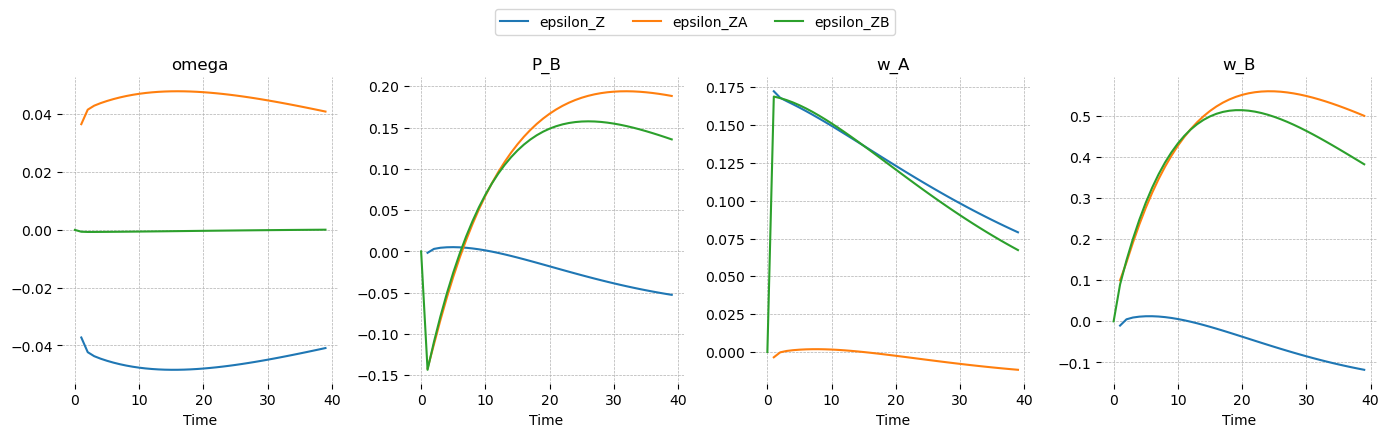

In [219]:
gp.plot_irf(irf.iloc[:, 2:], vars_to_plot=['omega', 'P_B', 'w_A', 'w_B'], legend=True, figsize=(14,4));

In [1058]:
from gEconpy.parser.file_loaders import load_gcn
from gEconpy.parser.gEcon_parser import preprocess_gcn, split_gcn_into_block_dictionary, rebuild_eqs_from_parser_output, split_gcn_into_block_dictionary, parsed_block_to_dict
from gEconpy.parser.parse_equations import build_sympy_equations

import pyparsing

file = load_gcn('../gcn_files/2_region.gcn')
parser_output, prior_dict = preprocess_gcn(file)
block_dicts = split_gcn_into_block_dictionary(parser_output)

ss_block = parsed_block_to_dict(block_dicts['STEADY_STATE'])

for i, (component, equations) in enumerate(ss_block.items()):
    ss_block[component], flags = list(
        zip(*build_sympy_equations(equations, block_dicts['assumptions']))
    )


TypeError: 'Equality' object is not iterable

In [1059]:
build_sympy_equations(equations, block_dicts['assumptions'])

[Eq(gamma, (alpha_C**(1/psi_C) + (1 - alpha_C)**(1/psi_C))**((-psi_C)/(psi_C - 1*1))),
 Eq(chi, P_nu_A_ss*mc_A_ss + P_nu_B_ss*mc_B_ss)]

In [1050]:
ss_block

defaultdict(list,
            {'definitions': [['gamma',
               '=',
               '(',
               'alpha_C',
               '^',
               '(',
               '1',
               '/',
               'psi_C',
               ')',
               '+',
               '(',
               '1',
               '-',
               'alpha_C',
               ')',
               '^',
               '(',
               '1',
               '/',
               'psi_C',
               ')',
               ')',
               '^',
               '(',
               '-',
               'psi_C',
               '/',
               '(',
               'psi_C',
               '-',
               '1',
               ')',
               ')'],
              ['chi',
               '=',
               'P_nu_A[ss]',
               '*',
               'mc_A[ss]',
               '+',
               'P_nu_B[ss]',
               '*',
               'mc_B[ss]']],
             'identities': [['shock_pr

In [1011]:
parser_output

'assumptions { positive { Theta, alpha, alpha_C, beta, delta, eta_p, gamma_I, gamma_R, gamma_Y, gamma_pi, phi_H, phi_pi_obj, pi_star, psi_C, psi_p, rho_pi_dot, rho_preference, rho_technology, sigma_C, sigma_L, r[], pi[], P_A[], P_B[], P_A_star[], P_B_star[], P_nu_A[], P_nu_B[], r_G[], w[], Y[], Y_A[], Y_B[], Y_f_A[], Y_f_B[], L_A[], L_B[], L_d_A[], L_d_B[], K_A[], K_B[], K_d_A[], K_d_B[], L[], K[] ; }; }; block STEADY_STATE { definitions { gamma = ( alpha_C ^ ( 1 / psi_C ) + ( 1 - alpha_C ) ^ ( 1 / psi_C ) ) ^ ( - psi_C / ( psi_C - 1 ) ) ; chi = P_nu_A[ss] * mc_A[ss] + P_nu_B[ss] * mc_B[ss] ; }; identities { shock_preference[ss] = 1 ; shock_preference[ss] = 1 ; shock_technology[ss] = 1 ; pi_obj[ss] = phi_pi_obj ; pi[ss] = pi_star ; P_A[ss] = ( alpha_C + ( 1 - alpha_C ) * ( ( 1 - alpha_C ) / alpha_C ) ^ ( ( 1 - psi_C ) / psi_C ) ) ^ ( - 1 / ( 1 - psi_C ) ) ; P_B[ss] = ( ( 1 - alpha_C ) / alpha_C ) ^ ( 1 / psi_C ) * P_A[ss] ; P_A_star[ss] = ( ( 1 - eta_p * pi[ss] ^ ( 1 / psi_p ) ) / ( 1 

In [853]:
ss_rels = list(mod.steady_state_relationships.values())
cse_dict, ss_rels_subbed = sp.cse(ss_rels)

In [854]:
ss_dict_2 = {k:v for k, v in zip(mod.steady_state_relationships.to_sympy().keys(), ss_rels_subbed)}

In [855]:
shock_subs =  {k.to_ss():0 for k in mod.shocks}
ss_eqs = [eq_to_ss(eq).subs(ss_dict_2).subs(shock_subs) for eq in mod.system_equations]

mod.free_param_dict.update({'pi_star':1.02, 'psi_C':0.6, 'psi_p':0.6, 'alpha_C':0.4})
resids = [eq.subs(cse_dict).subs(mod.free_param_dict.to_sympy()).evalf() for eq in ss_eqs]

f_resid = make_python_func(list(mod.free_param_dict.keys()), cse_dict, resids)

In [859]:
ss_vars

[C_ss,
 Div_A_ss,
 Div_B_ss,
 Div_Y_ss,
 Div_ss,
 I_ss,
 K_d_A_ss,
 K_d_B_ss,
 K_ss,
 LHS_A_ss,
 LHS_B_ss,
 L_A_ss,
 L_B_ss,
 L_ss,
 P_A_star_ss,
 P_A_ss,
 P_B_star_ss,
 P_B_ss,
 P_nu_A_ss,
 P_nu_B_ss,
 RHS_A_ss,
 RHS_B_ss,
 TC_A_ss,
 TC_B_ss,
 TC_Y_ss,
 U_ss,
 Y_A_ss,
 Y_B_ss,
 Y_f_A_ss,
 Y_f_B_ss,
 Y_ss,
 lambda__H_1_ss,
 lambda__H_2_ss,
 lambda_ss,
 mc_A_ss,
 mc_B_ss,
 omega_ss,
 pi_obj_ss,
 pi_ss,
 q_ss,
 r_G_ss,
 r_ss,
 shock_preference_ss,
 shock_technology_ss,
 w_A_ss,
 w_B_ss]

In [868]:
omega_solved = (sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[-1])
         .replace(L_B, 1 - L_A)
         .simplify()
         .replace(L_A ** (sigma_L + 1) + (1 - L_A) ** (1 + sigma_L), 1).simplify(), omega)[0]
    .subs(shock_preference, 1)
    .simplify()
    .subs({lambda__H_1:lam * w_A, lambda__H_2:lam * w_B})
    .expand()
    .collect(psi_omega ** 2 * L / phi_1))

In [873]:
sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[-3]), lambda__H_1, dict=True)

[{lambda__H_1_ss: lambda_ss*w_A_ss}]

In [935]:
labor_supply = ((eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[-4])
    .subs(sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[-3]), lambda__H_1, dict=True)[0])
    .subs(sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[-2]), lambda__H_2, dict=True)[0])
    .subs(sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[5]), lam, dict=True)[0])
    .subs({shock_preference:1})
    .expand()
    .collect(C ** -sigma_C)
    .collect(omega)
    .subs({omega: omega_solved})
    .expand()
    .collect(C ** -sigma_C * psi_omega ** 2 / phi_1 * L)
    .replace( -w_A **2 + 2 * w_A * w_B - w_B ** 2, -(w_A - w_B) ** 2)
) / C ** -sigma_C).simplify().collect(psi_omega)

In [937]:
sp.solve(labor_supply, L)

NotImplementedError: multiple generators [L_ss, L_ss**sigma_L]
No algorithms are implemented to solve equation -Theta*C_ss**sigma_C*L_ss**sigma_L + psi_omega*(w_A_ss - w_B_ss) + w_B_ss - psi_omega**2*L_ss*(w_A_ss - w_B_ss)**2/phi_1

In [892]:
mod.steady_state(mode='minimize')

KeyboardInterrupt: 

In [857]:
for eq in mod.blocks['HOUSEHOLD'].system_equations:
    display(eq)

phi_1*(-1*1 + omega_t/psi_omega)**2/2 + phi_2*(omega_t/omega_t-1 - 1*1)**2*omega_t/2 - B_t/r_G_t + B_t-1/pi_t - C_t + Div_t - I_t + K_t-1*r_t + L_A_t*w_A_t + L_B_t*w_B_t

I_t*(1 - gamma_I*(I_t/I_t-1 - 1*1)**2/2) - K_t + K_t-1*(1 - delta)

-L_A_t + L_t*omega_t

-L_B_t + L_t*(1 - omega_t)

beta*U_t+1 - U_t + shock_preference_t*(-Theta*L_t**(sigma_L + 1)/(sigma_L + 1) + C_t**(1 - sigma_C)/(1 - sigma_C))

-lambda_t + shock_preference_t/C_t**sigma_C

beta*gamma_I*I_t+1**2*q_t+1*(-1 + I_t+1/I_t)/I_t**2 - lambda_t - q_t*(gamma_I*I_t*(I_t/I_t-1 - 1)/I_t-1 + gamma_I*(I_t/I_t-1 - 1*1)**2/2 - 1)

beta*(lambda_t+1*r_t+1 - q_t+1*(delta - 1)) - q_t

beta*lambda_t+1/pi_t+1 - lambda_t/r_G_t

-Theta*L_t**sigma_L*shock_preference_t + lambda__H_1_t*omega_t - lambda__H_2_t*(omega_t - 1)

-lambda__H_1_t + lambda_t*w_A_t

-lambda__H_2_t + lambda_t*w_B_t

-beta*phi_2*lambda_t+1*omega_t+1**2*(-1 + omega_t+1/omega_t)/omega_t**2 + L_t*lambda__H_1_t - L_t*lambda__H_2_t - lambda_t*(-phi_1*(-1 + omega_t/psi_omega)/psi_omega - phi_2*omega_t*(omega_t/omega_t-1 - 1)/omega_t-1 - phi_2*(omega_t/omega_t-1 - 1*1)**2/2)

In [831]:
mod.free_param_dict.update({'phi_1':1, 'phi_2':1})
for i, x in enumerate(f_resid(**mod.free_param_dict)):
    if abs(x) > 1e-12:
        print(i, x)

NameError: name 'omega_ss' is not defined

In [722]:
for i, eq in enumerate(resids):
    print(i, eq)
#     print(mod.system_equations[i])

0 0.5*x62 + 0.5*x63 - x43*x61/x31
1 0.5*x62 + 0.5*x63 - x46*x61/x36
2 -x1*(x44 + x47) - x29*x43 - x29*x46 + x34*x43*x61 + x34*x46*x61 - 0.35*x43 - 0.35*x46 - 0.025*x48 + x49 - x55 + 2.0*(x2*((0.5*x35 + 0.5*x37)**x38/(x28*x29)**1.5)**0.5/(-x1 - 0.00875*x28))**0.571428571428571/(0.4**x4 + x5**x4)**(2.5*x3)
3 -0.025*x44 - 0.025*x47 + 0.025*x48
4 0
5 -1/x50**2.0 + 1.0/(-x40 - x49)**2.0
6 0
7 -0.99*x1/x50**2.0 - 0.0347500000000001/x50**2.0
8 0
9 -1.0*(x62 + x63)**1.5
10 0
11 0
12 -x13*x41 + x40 - x41*x54 + x55 + 1.0*(x2*((0.5*x35 + 0.5*x37)**x38/(x28*x29)**1.5)**0.5/(-x1 - 0.00875*x28))**0.571428571428571
13 1.9350438789185*(x39*x6)**1.0 - 1.0*(x2*((0.5*x35 + 0.5*x37)**x38/(x28*x29)**1.5)**0.5/(-x1 - 0.00875*x28))**0.571428571428571
14 -x13*x23*x39*x6 + x13*x41 - x39*x6/(x11**(x12*x3)*x5 + 0.4)**(1/x12) + x41*x54
15 0.652506258228553*(x39*x6)**2.22044604925031e-16 - 1/(x11**(x12*x3)*x5 + 0.4)**(1/x12)
16 -x13*x23 + 1.28253762068995*(x39*x6)**2.22044604925031e-16
17 0
18 -x16*x41 + 1.0*(x32*

In [542]:
(eq_to_ss(mod.blocks['HOME_CONSUMPTION_PRODUCTION'].system_equations[2])
    .subs())

-Y_t + (alpha_C**(1/psi_C)*Y_A_t**((psi_C - 1*1)/psi_C) + Y_B_t**((psi_C - 1*1)/psi_C)*(1 - alpha_C)**(1/psi_C))**(psi_C/(psi_C - 1*1))

In [550]:
eq = 1 - (alpha_C * P_A ** (1 - psi_C) + (1 - alpha_C) * P_B ** (1 - psi_C))
sp.solve(eq, P_A)[0].collect(P_B ** (1 - psi_C))

alpha_C**(1/(psi_C - 1))/(P_B_ss**(1 - psi_C)*(alpha_C - 1) + 1)**(1/(psi_C - 1))

In [574]:
x = sp.Symbol('x', positive=True, real=True)
mc_Y = TimeAwareSymbol('mc_Y', 0, real=True).to_ss()

In [584]:
eq1 = P_A - Y ** (1 / psi_C) * alpha_C ** (1 / psi_C) * Y_A ** (-1 / psi_C)
eq2 = P_B - Y ** (1 / psi_C) * (1 - alpha_C) ** (1 / psi_C) * Y_B ** (-1 / psi_C)

In [592]:
Y_bar = sp.Symbol('Y_bar', positive=True, real=True)

In [604]:
sp.solve(eq2, Y_B)[0]

Y_ss*((1 - alpha_C)**(1/psi_C)/P_B_ss)**psi_C

In [645]:
P_B_solved = sp.solve(sp.solve(eq1, Y_A)[0] - sp.solve(eq2, Y_B)[0], P_B)[0]

In [606]:
eq3 = 1 - (alpha_C * P_A ** (1 - psi_C) + (1 - alpha_C) * P_B ** (1 - psi_C))

In [658]:
P_B_solved.replace(1 - alpha_C, x).simplify().replace(x, 1 - alpha_C)

(P_A_ss**psi_C*(1 - alpha_C)/alpha_C)**(1/psi_C)

In [676]:
sp.solve(eq3.subs({P_B:P_B_solved}).replace(1 - alpha_C, x).powsimp().replace(x, 1 - alpha_C), P_A)[0]

alpha_C**(1/psi_C)/(1/(alpha_C**(1/psi_C) + (1 - alpha_C)**(1/psi_C)))**(1/(psi_C - 1))

In [669]:
sp.solve(eq3.subs({P_B:P_B_solved}).replace(1 - alpha_C, x).simplify(), P_A)[0].replace(x, 1 - alpha_C).simplify().collect(alpha_C)

(alpha_C*(alpha_C**(1/psi_C) + (1 - alpha_C)**(1/psi_C)))**(1/(psi_C - 1))/alpha_C**(1/(psi_C*(psi_C - 1)))

In [615]:
((eq_to_ss(mod.blocks['HOME_CONSUMPTION_PRODUCTION'].system_equations[-2]) - eq_to_ss(mod.blocks['HOME_CONSUMPTION_PRODUCTION'].system_equations[-1]))
    .subs({Y_A:Y_bar, Y_B:Y_bar, mc_Y:1})
    .replace(1 - alpha_C, x)
    .simplify()
    .collect((alpha_C ** (1 / psi_C) + x ** (1 / psi_C)) ** (1 / (psi_C - 1)))
     )

(Y_bar**(1/psi_C)*(-P_A_ss + P_B_ss) + alpha_C**(1/psi_C)*(Y_bar**((psi_C - 1)/psi_C)*(alpha_C**(1/psi_C) + x**(1/psi_C)))**(1/(psi_C - 1)) - x**(1/psi_C)*(Y_bar**((psi_C - 1)/psi_C)*(alpha_C**(1/psi_C) + x**(1/psi_C)))**(1/(psi_C - 1)))/Y_bar**(1/psi_C)

In [322]:
labor_supply = eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[-1]).subs({shock_preference: 1}).subs({L:L_A + L_B})
labor_demand = (eq_to_ss(mod.blocks['FIRM_A'].system_equations[-1] + mod.blocks['FIRM_B'].system_equations[-1]).subs({shock_technology:1}))

In [347]:
L_d_A_solved = sp.solve(eq_to_ss(mod.blocks['FIRM_A'].system_equations[-1]).subs({shock_technology:1}).replace((K_d_A / L_d_A) ** alpha, Y_f_A / L_d_A), L_d_A)[0]
L_d_B_solved = sp.solve(eq_to_ss(mod.blocks['FIRM_B'].system_equations[-1]).subs({shock_technology:1}).replace((K_d_B / L_d_B) ** alpha, Y_f_B / L_d_B), L_d_B)[0]

L_d_A_solved = L_d_A_solved.subs({Y_f_A:P_nu_A * Y_A})
L_d_B_solved = L_d_B_solved.subs({Y_f_B:P_nu_B * Y_B})


In [360]:
lam = ss_vars[31]

In [394]:
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol
Y_bar = TimeAwareSymbol('Y_bar', 0).to_ss()
C_solved = sp.solve(labor_supply.subs({L_A:L_d_A_solved, L_B:L_d_B_solved, Y_A:Y_bar, Y_B:Y_bar}).subs({lam:C ** -sigma_C}), C)[0]
C_solved = C_solved.collect(P_nu_A).collect(P_nu_B).collect(mc_A).collect(mc_B).collect(1 - alpha)

chi = sp.Symbol('chi')
C_solved = C_solved.replace(P_nu_A * mc_A + P_nu_B * mc_B, chi)

In [682]:
labor_supply

-Theta*(L_A_ss + L_B_ss)**sigma_L + lambda_ss*w_ss

In [389]:
Y_bar_solved = sp.solve(eq_to_ss(mod.blocks['HOME_CONSUMPTION_PRODUCTION'].system_equations[2]).subs({Y_A:Y_bar, Y_B:Y_bar}), Y_bar)[0]

In [461]:
mod.blocks['HOME_CONSUMPTION_PRODUCTION'].system_equations[2].subs({Y_A:Y_bar, Y_B:Y_bar}),

(-Y_t + (alpha_C**(1/psi_C)*Y_A_t**((psi_C - 1*1)/psi_C) + Y_B_t**((psi_C - 1*1)/psi_C)*(1 - alpha_C)**(1/psi_C))**(psi_C/(psi_C - 1*1)),)

In [460]:
Y_bar_solved

Y_ss/(alpha_C**(1/psi_C) + (1 - alpha_C)**(1/psi_C))**(psi_C/(psi_C - 1))

In [392]:
gamma =  sp.Symbol('gamma')
Y_bar_solved_2 = gamma * Y

In [400]:
C_solved = C_solved.replace(Y_bar, Y_bar_solved_2)

In [401]:
C_solved

(w_ss**(sigma_L + 1)/(Theta*(chi*gamma*Y_ss*(1 - alpha))**sigma_L))**(1/sigma_C)

In [408]:
sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[1]).subs({shock_preference: 1}).subs({K:K_A + K_B}).simplify().collect(delta), I)

delta*(-K_A_ss - K_B_ss) + I_ss

In [404]:
mod.blocks['HOUSEHOLD'].system_equations[1]

I_t*(1 - gamma_I*(I_t/I_t-1 - 1*1)**2/2) - K_t + K_t-1*(1 - delta)

In [442]:
capital_supply = sp.solve(eq_to_ss(mod.blocks['HOUSEHOLD'].system_equations[1]).subs({shock_preference: 1}).subs({K:K_A + K_B}).simplify().collect(delta), I)[0]
capital_demand = (eq_to_ss(mod.blocks['FIRM_A'].system_equations[-2] + mod.blocks['FIRM_B'].system_equations[-2]).subs({shock_technology:1}))

In [436]:
K_d_A_solved = sp.solve(eq_to_ss(mod.blocks['FIRM_A'].system_equations[-2]).subs({shock_technology:1}).replace(K_d_A ** (alpha - 1), Y_f_A).replace(L_d_A ** (1 - alpha), 1/ K_d_A), K_d_A)[0]
K_d_B_solved = sp.solve(eq_to_ss(mod.blocks['FIRM_B'].system_equations[-2]).subs({shock_technology:1}).replace(K_d_B ** (alpha - 1), Y_f_B).replace(L_d_B ** (1 - alpha), 1/ K_d_B), K_d_B)[0]

K_d_A_solved = K_d_A_solved.subs({Y_f_A:P_nu_A * Y_A})
K_d_B_solved = K_d_B_solved.subs({Y_f_B:P_nu_B * Y_B})


In [512]:
capital_supply

delta*(K_A_ss + K_B_ss)

In [455]:
I_solved = sp.solve((I - capital_supply.subs({K_A:K_d_A_solved, K_B:K_d_B_solved}).subs({Y_A:Y_bar, Y_B:Y_bar})), I)[0]
I_solved = I_solved.replace(P_nu_A * mc_A + P_nu_B * mc_B, chi)
I_solved = I_solved.replace(Y_bar, Y_bar_solved_2)

In [490]:
Y_solved = sp.solve(Y - C_solved.replace(Y, 1) * Y ** (-sigma_L / sigma_C) - I_solved, Y)[0]

In [513]:
print(Y_solved)

(-r_ss*(w_ss**(sigma_L + 1)/(Theta*(-chi*gamma*(alpha - 1))**sigma_L))**(1/sigma_C)/(alpha*chi*delta*gamma - r_ss))**(sigma_C/(sigma_C + sigma_L))


0 -0.704877591062884
-C_t + Div_t - I_t + K_t-1*r_t + L_t*w_t
13 -0.787770390728729
-P_B_t + Y_B_t**(-1 + (psi_C - 1)/psi_C)*(1 - alpha_C)**(1/psi_C)*(alpha_C**(1/psi_C)*Y_A_t**((psi_C - 1*1)/psi_C) + Y_B_t**((psi_C - 1*1)/psi_C)*(1 - alpha_C)**(1/psi_C))**(psi_C/(psi_C - 1*1) - 1)
26 0.201856331277145
K_d_B_t**alpha*L_d_B_t**(1 - alpha)*shock_technology_t - Y_f_B_t
28 0.0139411857308194
alpha*K_d_B_t**(alpha - 1)*L_d_B_t**(1 - alpha)*mc_B_t*shock_technology_t - r_t
29 0.440941319583455
mc_B_t*shock_technology_t*(K_d_B_t/L_d_B_t)**alpha*(1 - alpha) - w_t


In [639]:
mod.steady_state()

KeyboardInterrupt: 

In [555]:
mc_Y

NameError: name 'mc_Y' is not defined

In [637]:
mod.print_steady_state()

C_ss                         1.207
Div_A_ss                     0.234
Div_B_ss                     0.234
Div_Y_ss                    -0.000
Div_ss                       0.469
I_ss                         0.245
K_d_A_ss                     4.901
K_d_B_ss                     4.901
K_ss                         9.802
LHS_A_ss                     2.011
LHS_B_ss                     2.011
L_d_A_ss                     0.360
L_d_B_ss                     0.360
L_ss                         0.719
P_A_ss                       1.000
P_A_star_ss                  0.938
P_B_ss                       1.000
P_B_star_ss                  0.938
P_nu_A_ss                    1.236
P_nu_B_ss                    1.236
RHS_A_ss                     1.257
RHS_B_ss                     1.257
TC_A_ss                     -0.492
TC_B_ss                     -0.492
TC_Y_ss                     -1.452
U_ss                      -100.442
Y_A_ss                       0.726
Y_B_ss                       0.726
Y_f_A_ss            

In [632]:
mod.solve_model(not_loglin_variable=['Div_Y'], solver='gensys')

[0, 0, 10]
Norm of deterministic part: 16441820.985027658
Norm of stochastic part:    16441820.985027658


In [633]:
mod.T

,C,Div,Div_A,Div_B,Div_Y,I,K,K_d_A,K_d_B,L,...,mc_A,mc_B,pi,pi_obj,q,r,r_G,shock_preference,shock_technology,w
C,8.804100,5.066300,-48.283416,58.416017,1.946578e-13,0.281541,385.216325,-52.249098,-98.049434,-13.222721,...,19.448410,19.448410,17.637161,-8.070487,-27.468071,59.700665,54.017418,-96.950857,296.580346,-2.225880
Div,1112.810196,-442.007026,-6033.631675,5149.617624,2.358112e-11,-38.692418,41955.285895,-6073.615842,-10610.255456,-1545.273515,...,2286.541866,2286.541866,2057.281739,-1143.793963,-4980.790423,6704.372254,8138.085869,-504.088012,35014.497463,-92.289881
Div_A,1112.871790,-442.108982,-6033.571191,5149.353226,2.358304e-11,-38.717280,41955.435124,-6073.748707,-10610.304740,-1545.331640,...,2286.589399,2286.589399,2057.259468,-1143.538339,-4980.598677,6704.441204,8138.541820,-503.608255,35016.285323,-92.253880
Div_B,1112.757888,-441.853276,-6033.726893,5150.020341,2.357908e-11,-38.651538,41954.849811,-6073.286337,-10610.077731,-1545.206246,...,2286.472932,2286.472932,2057.323562,-1144.054048,-4980.841848,6704.182194,8137.508429,-504.815769,35012.725168,-92.293594
Div_Y,-0.002622,-0.015599,0.010056,-0.041254,2.220858e-17,-0.004502,0.073963,-0.055301,-0.035167,-0.002525,...,0.005916,0.005916,-0.005946,0.001250,-0.042037,0.033677,0.036402,0.072157,-0.013405,-0.009032
I,3.633896,17.843920,-19.945667,55.633506,1.249293e-13,0.415039,312.396957,-45.619787,-82.800489,-8.920892,...,13.237689,13.237689,9.483579,3.040766,11.889287,49.175699,11.773168,-290.442689,194.698433,-6.113547
K,-0.488991,-1.974590,2.550579,-6.499760,-1.007451e-14,-0.217075,-24.467312,2.062058,6.422595,0.770659,...,-1.037076,-1.037076,-1.101301,0.241338,-1.922255,-3.293660,-0.337489,13.763125,-18.941210,0.178007
K_d_A,-0.598619,-2.535041,3.085831,-8.155914,-1.458245e-14,-0.232592,-33.483520,3.335912,8.755367,1.026892,...,-1.413461,-1.413461,-1.386982,0.288661,-2.555463,-4.675647,-0.601002,21.024715,-24.208431,0.343100
K_d_B,-0.592900,-2.435629,3.165522,-8.036780,-1.250337e-14,-0.236609,-32.644542,3.206561,8.643577,1.010752,...,-1.389684,-1.389684,-1.360515,0.047327,-1.999998,-4.583990,-0.675241,22.093596,-24.577563,0.330327
L,-4073.752365,1614.013471,22088.137648,-18860.110706,-8.638561e-11,143.264559,-153741.109808,22269.977641,38883.418463,5660.711062,...,-8377.033583,-8377.033583,-7532.502997,4179.851880,18233.004771,-24572.425127,-29803.374204,2076.355646,-128251.299559,343.561863
